# Import library

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, LSTM
from matplotlib.animation import FuncAnimation
from math import sqrt
from sklearn.metrics import mean_squared_error

In [85]:
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline

# 1. Read data

In [86]:
VNIndex = pd.read_csv('https://raw.githubusercontent.com/grassnhi/AI_ML_DL/main/AppWeb/Data/VNI.csv',
                        parse_dates=['Date'], index_col='Date').filter(['Price'])
VNItest = pd.read_csv('https://raw.githubusercontent.com/grassnhi/AI_ML_DL/main/CSVFile/VNItest.csv',
                        parse_dates=['Date'], index_col='Date').filter(['Price'])

VNIndex["Price"] = pd.to_numeric(VNIndex["Price"].apply(lambda x: x.replace(",", "")))
VNItest["Price"] = VNItest["Price"].str.replace(',', '').astype(float)

VNIndex = VNIndex.iloc[::-1]
VNItest = VNItest.iloc[::-1]

# 2. Visualize

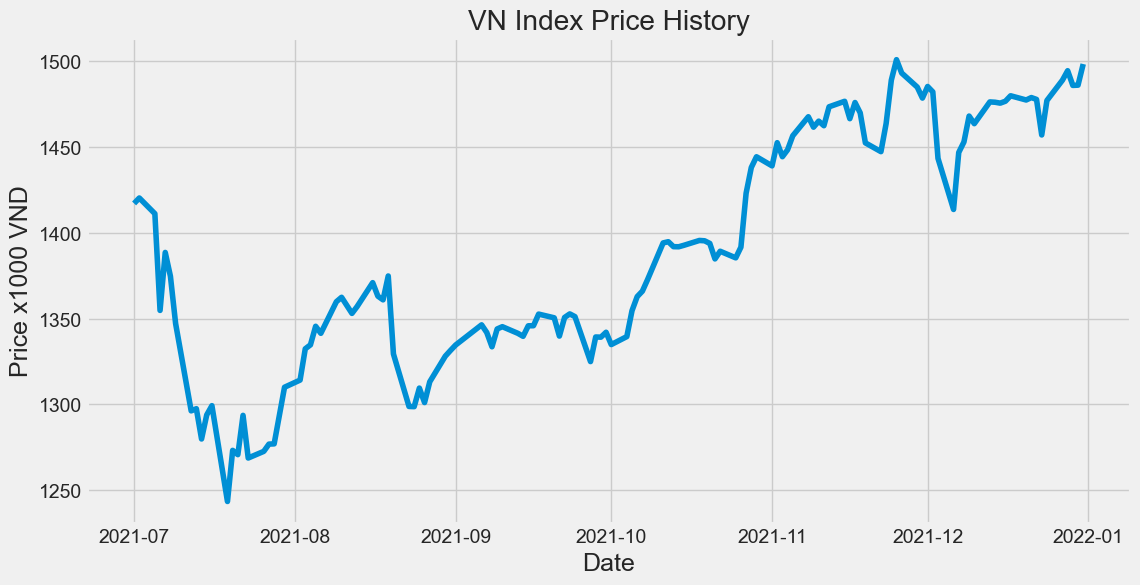

In [87]:
plt.figure(figsize=(12,6))
plt.title('VN Index Price History')
plt.plot(VNIndex['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.show()

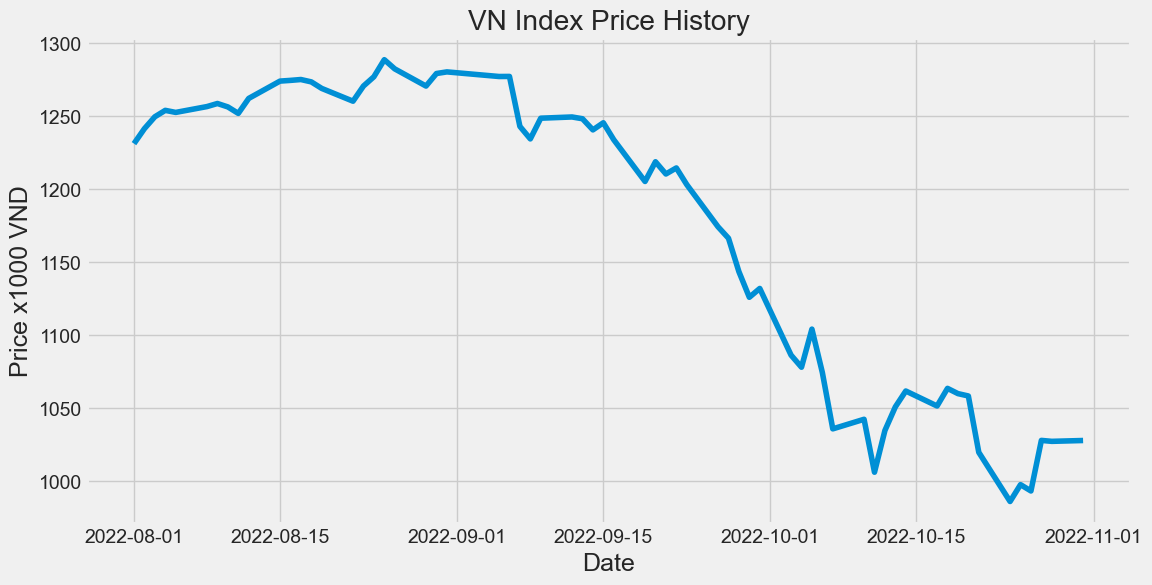

In [88]:
plt.figure(figsize=(12,6))
plt.title('VN Index Price History')
plt.plot(VNItest['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.show()

# 3. Preprocess data

In [89]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(VNIndex)
scaled_test = scaler.fit_transform(VNItest)
#scaled_data

In [90]:
dataset = VNIndex.values
training_data_len = int(np.ceil(len(dataset) * .9))
# training_data_len

In [91]:
time_step = 5

In [92]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(time_step, len(train_data)):
    x_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(112, 5, 1)

# 4. Build model

In [93]:
from datetime import datetime

In [94]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(128, input_shape= (x_train.shape[1], 1)))
model.add(Dense(8))
model.add(Dense(1))


In [95]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 256)            264192    
                                                                 
 lstm_15 (LSTM)              (None, 128)               197120    
                                                                 
 dense_17 (Dense)            (None, 8)                 1032      
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 462,353
Trainable params: 462,353
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [102]:
history = model.fit(x_train, y_train, batch_size = 10, shuffle = False, epochs = 5)

Epoch 1/5
12/12 [==============================] - 2s 16ms/step - loss: 0.0151
Epoch 2/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0127
Epoch 3/5
12/12 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 4/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0115
Epoch 5/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0116


# 5. Prediction

In [104]:
test_data = scaled_data[training_data_len - time_step: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(time_step, len(test_data)):
    x_test.append(test_data[i-time_step:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


1/1 [==============================] - 0s 31ms/step


In [105]:
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Train RMSE - LSTM: %.3f' % mean_squared_error(y_train, model.predict(x_train)))
print('Test RMSE - LSTM: %.3f' % rmse)

4/4 [==============================] - 0s 9ms/step
Train RMSE - LSTM: 0.011
Test RMSE - LSTM: 226.952


In [106]:
train = VNIndex[:training_data_len]
pred = VNIndex[training_data_len:]
pred['Predictions'] = predictions
pred

C:\Users\PC\AppData\Local\Temp\ipykernel_15844\3633136035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['Predictions'] = predictions


,Price,Predictions
Date,,
2021-12-15,1475.50,1243.076904
2021-12-16,1476.61,1249.123047
2021-12-17,1479.79,1251.198975
2021-12-20,1477.33,1255.240479
2021-12-21,1478.74,1255.603638
2021-12-22,1477.67,1256.189697
2021-12-23,1456.96,1256.955200
2021-12-24,1477.03,1255.497803
2021-12-27,1488.88,1253.274170


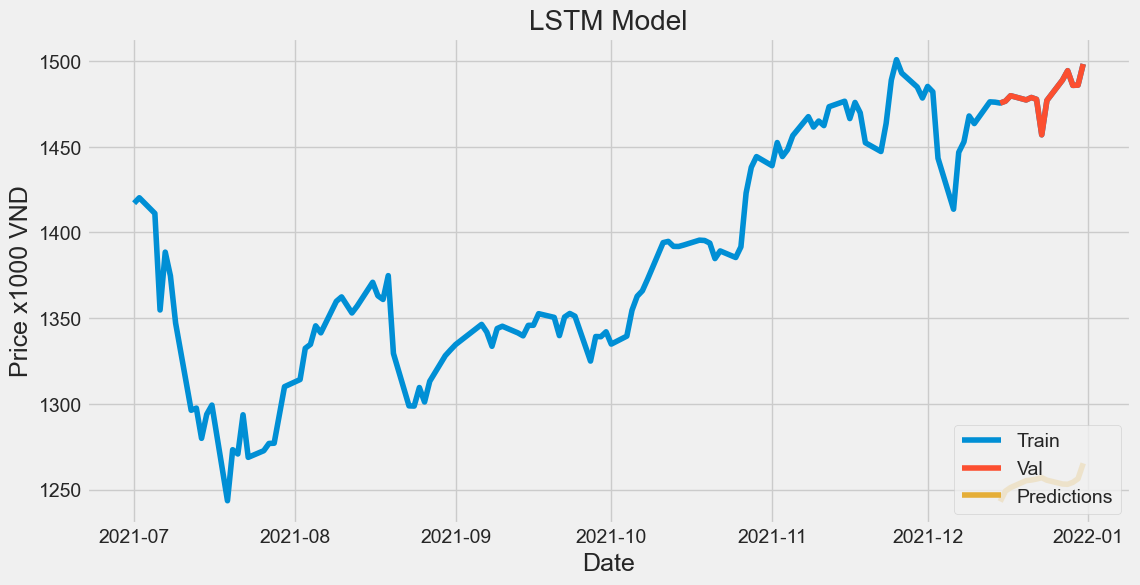

In [107]:
plt.figure(figsize=(12,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.plot(VNIndex['Price'])
plt.plot(pred[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()